In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score
from imblearn.under_sampling import RandomUnderSampler
import warnings
warnings.filterwarnings('ignore')

In [ ]:
path = '/content/drive/MyDrive/Research/loan_chunks/loan_data_chunk_2.csv'

# Expanded list for a "Serious" project
features = [
    'loan_status', 'loan_amnt', 'term', 'int_rate', 'grade',
    'emp_length', 'home_ownership', 'annual_inc',
    'verification_status', 'purpose', 'dti', 'fico_range_low'
]

df = pd.read_csv(path, usecols=features)

df = df.dropna()

df = df[df['loan_status'].isin(['Fully Paid', 'Charged Off'])]

# Target encoding
df['loan_status'] = df['loan_status'].map({'Fully Paid': 0, 'Charged Off': 1})

print(df.shape)

(82686, 12)


In [ ]:
df.isnull().sum()

,0
loan_amnt,0
term,0
int_rate,0
grade,0
emp_length,0
home_ownership,0
annual_inc,0
verification_status,0
loan_status,0
purpose,0


In [ ]:
grade_map = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
df['grade'] = df['grade'].map(grade_map)

# For Verification: 'Verified' and 'Source Verified' are basically the same (1),
# 'Not Verified' is 0.
verify_map = {'Not Verified': 0, 'Source Verified': 1, 'Verified': 1}
df['verification_status'] = df['verification_status'].map(verify_map)

In [ ]:
df = pd.get_dummies(df, columns=['home_ownership', 'purpose'], drop_first=False)

df.head(5)

,loan_amnt,term,int_rate,grade,emp_length,annual_inc,verification_status,loan_status,dti,fico_range_low,...,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
0,6000.0,36 months,10.99,2,4 years,36000.0,1,1,20.83,685.0,...,False,False,False,False,False,False,False,False,False,False
1,8500.0,36 months,13.99,3,< 1 year,50000.0,0,0,31.61,680.0,...,False,False,True,False,False,False,False,False,False,False
2,11525.0,36 months,8.18,2,1 year,73000.0,0,0,22.31,670.0,...,False,False,False,False,False,False,False,False,False,False
4,15000.0,36 months,12.29,3,4 years,78000.0,1,0,13.55,695.0,...,False,False,False,False,False,False,False,False,False,False
5,8000.0,36 months,12.29,3,10+ years,90000.0,1,0,36.71,690.0,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
# Clean 'term' to just 36 or 60
df['term'] = df['term'].str.replace(' months', '').astype(int)

# Clean 'emp_length' to a simple number
df['emp_length'] = df['emp_length'].str.replace('\+ years', '', regex=True)
df['emp_length'] = df['emp_length'].str.replace(' years', '', regex=True)
df['emp_length'] = df['emp_length'].str.replace(' year', '', regex=True)
df['emp_length'] = df['emp_length'].str.replace('< 1', '0', regex=True)
df['emp_length'] = df['emp_length'].astype(int)

In [ ]:
df = df.astype(int)
df.head(5)

,loan_amnt,term,int_rate,grade,emp_length,annual_inc,verification_status,loan_status,dti,fico_range_low,...,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
0,6000,36,10,2,4,36000,1,1,20,685,...,0,0,0,0,0,0,0,0,0,0
1,8500,36,13,3,0,50000,0,0,31,680,...,0,0,1,0,0,0,0,0,0,0
2,11525,36,8,2,1,73000,0,0,22,670,...,0,0,0,0,0,0,0,0,0,0
4,15000,36,12,3,4,78000,1,0,13,695,...,0,0,0,0,0,0,0,0,0,0
5,8000,36,12,3,10,90000,1,0,36,690,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df.shape

(82686, 26)

In [ ]:
df['loan_status'].value_counts()

,count
loan_status,
0,66555
1,16131


In [ ]:
X = df.drop('loan_status', axis=1)

y = df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((66148, 25), (16538, 25), (66148,), (16538,))

In [ ]:
scaler = StandardScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# ONLY transform the test data (to keep it a fair test)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# 1. Perform Undersampling
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train_scaled, y_train)

# 2. Train Logistic Regression
log_model = LogisticRegression(solver='saga', random_state=42, n_jobs=-1)
log_model.fit(X_train_rus, y_train_rus)

# 3. Evaluate
y_pred_log = log_model.predict(X_test_scaled)
print("--- Logistic Regression (Undersampled) ---")
print(classification_report(y_test, y_pred_log))

--- Logistic Regression (Undersampled) ---
              precision    recall  f1-score   support

           0       0.89      0.71      0.79     13312
           1       0.35      0.64      0.45      3226

    accuracy                           0.70     16538
   macro avg       0.62      0.68      0.62     16538
weighted avg       0.79      0.70      0.72     16538



In [ ]:
rf_rus = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1)

rf_rus.fit(X_train_rus, y_train_rus)

y_pred_rus_rf = rf_rus.predict(X_test_scaled)
print("--- Random Forest (Undersampled) ---")
print(classification_report(y_test, y_pred_rus_rf))

--- Random Forest (Undersampled) ---
              precision    recall  f1-score   support

           0       0.89      0.66      0.76     13312
           1       0.32      0.66      0.43      3226

    accuracy                           0.66     16538
   macro avg       0.61      0.66      0.60     16538
weighted avg       0.78      0.66      0.70     16538



In [ ]:
# Initialize with class_weight='balanced'
rf_weighted = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)



rf_weighted.fit(X_train_scaled, y_train)

# Predict
y_pred_weighted = rf_weighted.predict(X_test_scaled)

In [ ]:
y_pred_weighted = rf_weighted.predict(X_test_scaled)
print("--- Weighted Random Forest Results ---")
print(classification_report(y_test, y_pred_weighted))

--- Weighted Random Forest Results ---
              precision    recall  f1-score   support

           0       0.89      0.71      0.79     13312
           1       0.35      0.64      0.45      3226

    accuracy                           0.69     16538
   macro avg       0.62      0.67      0.62     16538
weighted avg       0.78      0.69      0.72     16538



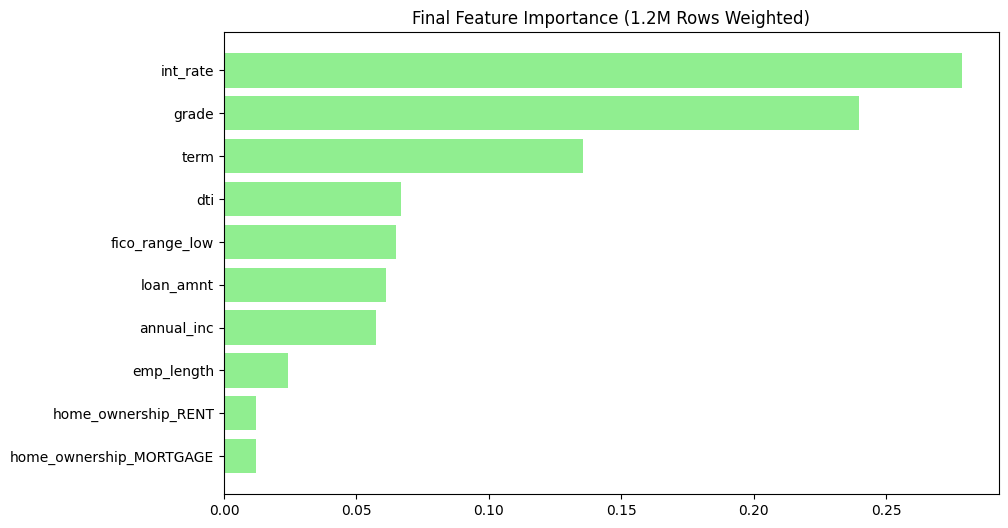

In [ ]:
# features from the weighted model
importances = rf_weighted.feature_importances_
feature_names = X.columns

feature_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_df = feature_df.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.barh(feature_df['Feature'], feature_df['Importance'], color='lightgreen')
plt.gca().invert_yaxis()
plt.title('Final Feature Importance (1.2M Rows Weighted)')
plt.show()

In [ ]:
# Collect metrics for all three models
models = ['Logistic (Undersampled)', 'RF (Undersampled)', 'RF (Weighted)']
predictions = [y_pred_log, y_pred_rus_rf, y_pred_weighted]

summary_data = []

for name, pred in zip(models, predictions):
    summary_data.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, pred),
        'Recall (Defaults)': recall_score(y_test, pred),
        'Precision (Defaults)': precision_score(y_test, pred)
    })

summary_df = pd.DataFrame(summary_data)

print("Final Model Comparison:")
print("-" * 30)
display(summary_df)

Final Model Comparison:
------------------------------


,Model,Accuracy,Recall (Defaults),Precision (Defaults)
0,Logistic (Undersampled),0.695731,0.644141,0.348541
1,RF (Undersampled),0.662474,0.660570,0.322001
2,RF (Weighted),0.693917,0.639492,0.346025


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

y_prob = rf_weighted.predict_proba(X_test_scaled)[:, 1]
roc_auc = roc_auc_score(y_test, y_prob)
print("ROC-AUC:", round(roc_auc, 4))

ROC-AUC: 0.7383


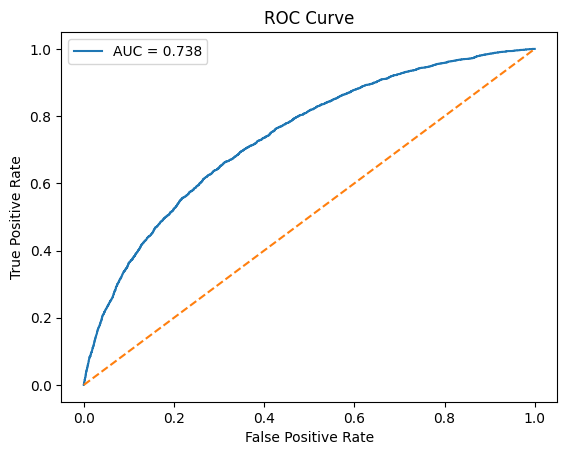

In [ ]:
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import matthews_corrcoef

y_pred_05 = (y_prob >= 0.5).astype(int)
mcc_05 = matthews_corrcoef(y_test, y_pred_05)

print("MCC (threshold=0.5):", round(mcc_05, 4))


MCC (threshold=0.5): 0.286


In [ ]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, matthews_corrcoef

thresholds = [0.2, 0.3, 0.4, 0.5]

results = []

for t in thresholds:
    y_pred_t = (y_prob >= t).astype(int)

    results.append({
        "Threshold": t,
        "Recall": recall_score(y_test, y_pred_t),
        "Precision": precision_score(y_test, y_pred_t),
        "MCC": matthews_corrcoef(y_test, y_pred_t)
    })

threshold_df = pd.DataFrame(results)
print(threshold_df)


   Threshold    Recall  Precision       MCC
0        0.2  0.966212   0.220782  0.156752
1        0.3  0.906076   0.250815  0.217329
2        0.4  0.789833   0.292168  0.258835
3        0.5  0.639492   0.346025  0.286038


In [ ]:
import joblib
import os

# Define the directory path
model_dir = "/content/drive/MyDrive/Research/model"

# Create the directory if it does not exist
os.makedirs(model_dir, exist_ok=True)

# Save trained model
joblib.dump(rf_weighted, os.path.join(model_dir, "rf_model.pkl"))

# Save feature column order
joblib.dump(X.columns.tolist(), os.path.join(model_dir, "feature_columns.pkl"))

['/content/drive/MyDrive/Research/model/feature_columns.pkl']